In [1]:
import os
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

# Model configuration

<img src='image/model_tree.png' width='1500' alt='pk tree' align='center' />

Refer to **"Integrated surface/subsurface permafrost thermal hydrology: Model formulation and proof‐of‐concept simulations" (Painter et al., 2016)** 

# Typical modeling steps

* column freezeup
    * subsurface flow-energy tree
    * Pressure of the top cell is slightly less than 101,325 Pa

<img src='image/model_tree_subs.png' width='200' alt='pk tree' align='center' />

* column/domain spinup
    * surface-subsurface, flow-energy full physics tree
    * cyclically stable status (subsurface water content becomes cyclically stable)

* domain transient run

# Saturation Partition

## Theory

* Three phases: gas, liquid water, ice.
* Saturations are determined by temperature and capillary pressue between phases.
* The pressure gradient between liquid water and ice (capillary pressure between ice and liquid) draws liquid water toward the freezing front in porous media during freezing period (**cryosuction**).
* Saturation model [refer to Painter & Karra (2014)]:

<img src='image/sat_math_declar.png' width='600' alt='saturation model' align='center' />

**With crysuction:**

<img src='image/cryosuction_xml.png' width='800' alt='pk tree' align='center' />

**Without crysuction:**

<img src='image/no_cryosuction_xml.png' width='800' alt='pk tree' align='center' />

## Example - Cryosuction vs. Non-cryosuction

| Parameter (Stuurop et al., 2021, Table 3)                    |          |                 
| :----------------------------------------------------------------- | :------: | 
| Sandy column                                                       | 20 cm    |
| Permeability ($\mathrm{m}^2$)                                      | 3.19e-13 |
| Porosity                                                           | 0.535    |
| Van Genuchten $\alpha$ ($\mathrm{Pa}^{-1}$)                        | 1.11e-4  |
| Van Genuchten m                                                    | 0.32     |
| Residual water saturation                                          | 0.093    |
| Thermal conductivity, unfrozen ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$) | 0.67     |
| Thermal conductivity, dry ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$)      | 0.07     |
| Initial temperature ($^\circ$C)                                    | 6.7      |
| Initial water content                                              | 0.34     |
| Top surface temperature ($^\circ$C)                                | -6       |
| Bottom surface boundary condition                                  | no flux  |
| Measured item                                                      | total water content |
| Measurement times (hours)                                          | 12, 24, 50 |

In [2]:
def get_thetaW(case, time_idx):
    with h5py.File('{}/ats_vis_data.h5'.format(case), 'r') as f:
        cell_volume = f['cell_volume']['0'][:,0]
        cycles = np.sort([int(c) for c in f['pressure'].keys()])
        wc_mols = f['water_content'][str(cycles[time_idx])][:,0]
        rho = f['molar_density_liquid'][str(cycles[time_idx])][:,0]
        theta_ice = f['saturation_ice'][str(cycles[time_idx])][:,0] * f['porosity'][str(cycles[time_idx])][:,0]
        
    return wc_mols/rho/cell_volume, theta_ice

In [3]:
df_labexp = pd.read_csv("data/labexp_Mizoguchi1990.csv")

wc_12h_cryo, ic_12h_cryo = get_thetaW('column-cryo', 12)
wc_24h_cryo, ic_24h_cryo = get_thetaW('column-cryo', 24)
wc_50h_cryo, ic_50h_cryo = get_thetaW('column-cryo', 50)

wc_12h_nocryo, ic_12h_nocryo = get_thetaW('column-nocryo', 12)
wc_24h_nocryo, ic_24h_nocryo = get_thetaW('column-nocryo', 24)
wc_50h_nocryo, ic_50h_nocryo = get_thetaW('column-nocryo', 50)

depth = np.arange(0.5, 20, 1)

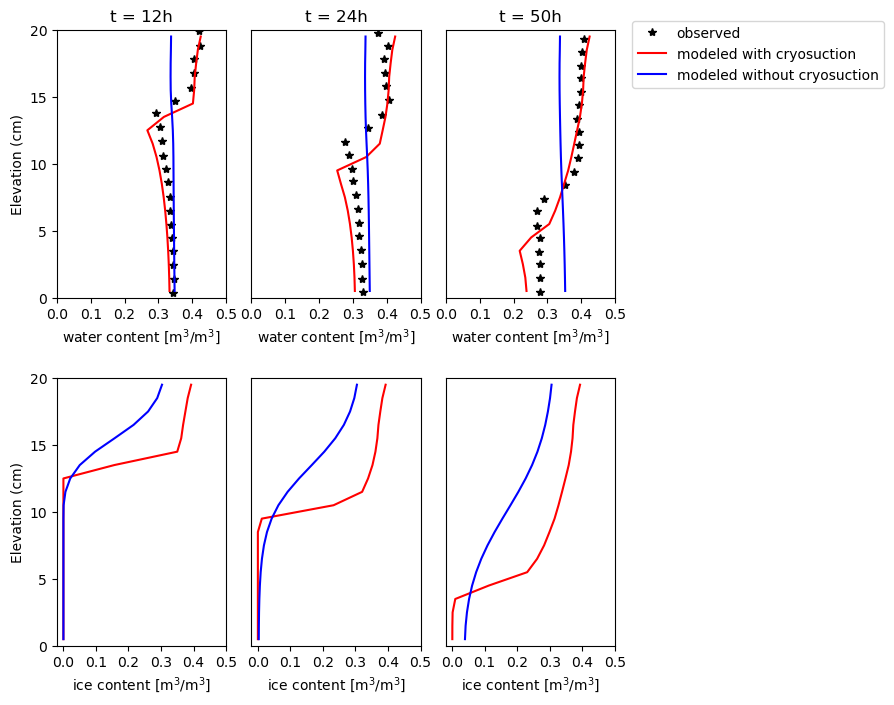

In [4]:
fig, ax = plt.subplots(2,3, figsize=(6,8))
plt.subplots_adjust(left=0.06, right=0.99, wspace=0.15, hspace=0.3)
df_labexp.plot(x='total_water_content_12h', y='z_12h', ax=ax[0][0], style='*', color='k', label='observed', legend=False, xlabel=r'water content [m$^3$/m$^3$]')
ax[0][0].plot(wc_12h_cryo, depth, 'r-', label='modeled with cryosuction')
ax[0][0].plot(wc_12h_nocryo, depth, 'b-', label='modeled without cryosuction')
ax[1][0].plot(ic_12h_cryo, depth, 'r-')
ax[1][0].plot(ic_12h_nocryo, depth, 'b-')

df_labexp.plot(x='total_water_content_24h', y='z_24h', ax=ax[0][1], style='*', color='k', yticks=[], legend=False, xlabel=r'water content [m$^3$/m$^3$]')
ax[0][1].plot(wc_24h_cryo, depth, 'r-')
ax[0][1].plot(wc_24h_nocryo, depth, 'b-')
ax[1][1].plot(ic_24h_cryo, depth, 'r-')
ax[1][1].plot(ic_24h_nocryo, depth, 'b-')

df_labexp.plot(x='total_water_content_50h', y='z_50h', ax=ax[0][2], style='*', color='k', yticks=[], legend=False, xlabel=r'water content [m$^3$/m$^3$]')
ax[0][2].plot(wc_50h_cryo, depth, 'r-')
ax[0][2].plot(wc_50h_nocryo, depth, 'b-')
ax[1][2].plot(ic_50h_cryo, depth, 'r-')
ax[1][2].plot(ic_50h_nocryo, depth, 'b-')


ax[0][0].set_title('t = 12h')
ax[0][1].set_title('t = 24h')
ax[0][2].set_title('t = 50h')

for i in range(3):
    for j in range(2):
        ax[j][i].set_xticks(np.arange(0, 0.51, 0.1))
        ax[j][i].set_ylim(0, 20)
    ax[1][i].set_xlabel(r'ice content [m$^3$/m$^3$]')
for i in range(1,3):
    ax[1][i].set_yticks([])
for i in range(2):
    ax[i][0].set_ylabel('Elevation (cm)')
    ax[i][0].set_yticks(np.arange(0, 20.1, 5))

handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=[1.45, 0.9]);

# Relative permeability

## ATS options

<img src='image/kr_options.png' width='1000' alt='pk tree' align='center' />

Normally used:
* water retention model + van Genuchten - Mualem
* freezing Brooks-Corey + Brooks-Corey
* SutraICE + Brooks-Corey

## Kr effect on discharge

<img src='image/hillslope_mesh.png' width='500' alt='pk tree' align='center' />

In [5]:
df_wrm_vg = pd.read_csv("hillslope-wrmVG_krWRMtypeVG/observation.dat", comment='#', delimiter=' ').iloc[365:-365].reset_index(drop=True)
df_frzbc_bc = pd.read_csv("hillslope-wrmVG_krFrzBCtypeBC/observation.dat", comment='#', delimiter=' ').iloc[365:-365].reset_index(drop=True)
df_sutraice_bc = pd.read_csv("hillslope-wrmVG_krSutraICEtypeBC/observation.dat", comment='#', delimiter=' ').iloc[365:-365].reset_index(drop=True)

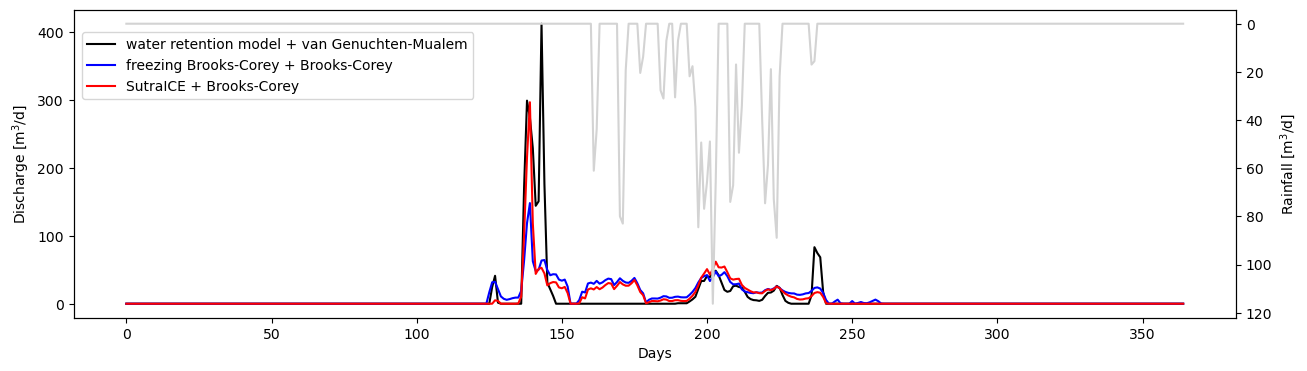

In [6]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
density = 55500
key = 'discharge [mol/d]'
(df_wrm_vg[key]/density).plot(ax=ax, label='water retention model + van Genuchten-Mualem', color='k')
(df_frzbc_bc[key]/density).plot(ax=ax, label='freezing Brooks-Corey + Brooks-Corey', color='b')
(df_sutraice_bc[key]/density).plot(ax=ax, label='SutraICE + Brooks-Corey', color='r')

ax2 = ax.twinx()
df_wrm_vg['rain [m3/d]'].plot(ax=ax2, color='lightgrey')
ax2.invert_yaxis()

ax.set_xlabel('Days')
ax.set_ylabel(r'Discharge [m$^3$/d]');
ax2.set_ylabel(r'Rainfall [m$^3$/d]');

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(0.35,0.95));

<img src='image/sat180d.png' width='1200' alt='pk tree' align='center' />
<img src='image/kr_options.png' width='1000' alt='pk tree' align='center' />

## Implementation in input files

<img src='image/wrmvg.png' width='700' alt='pk tree' align='center' />
<img src='image/wrmvg0.png' width='1000' alt='pk tree' align='center' />

<img src='image/krzbc.png' width='700' alt='pk tree' align='center' />
<img src='image/krzbc0.png' width='1000' alt='pk tree' align='center' />